## Data Loading and Preprocessing

According to the `README.md` from https://github.com/zalandoresearch/fashion-mnist, we can use this function from Tensorflow to load the dataset. And it's already split for us.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

(X_train, y_train), (X_test, y_test) =  tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [2]:
print(f"Train set shape: {X_train.shape, y_train.shape}\nTest set shape: {X_test.shape, y_test.shape}")

Train set shape: ((60000, 28, 28), (60000,))
Test set shape: ((10000, 28, 28), (10000,))


It would be more convenient to have the image as a flat vector, i.e. a 784-dimension Numpy array.

In [3]:
X_train: np.ndarray = X_train.reshape(X_train.shape[0], 784)
X_test: np.ndarray = X_test.reshape(X_test.shape[0], 784)

Let's have a look at some image.

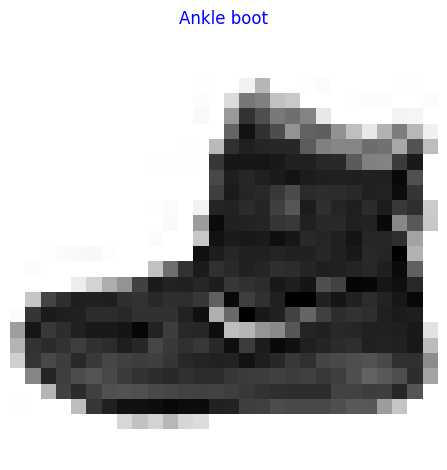

In [4]:
class_name = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

def plot_image(image_data: np.ndarray, label:int):
    image_data = image_data.reshape(28, 28)
    plt.imshow(image_data, cmap="binary")
    plt.title(class_name[label], color = "blue")
    plt.axis("off")
    plt.tight_layout()

plot_image(X_train[0], y_train[0])
plt.show()

An image doesn't tell very much though. Let's have a peek at the first 64 images from the train set.

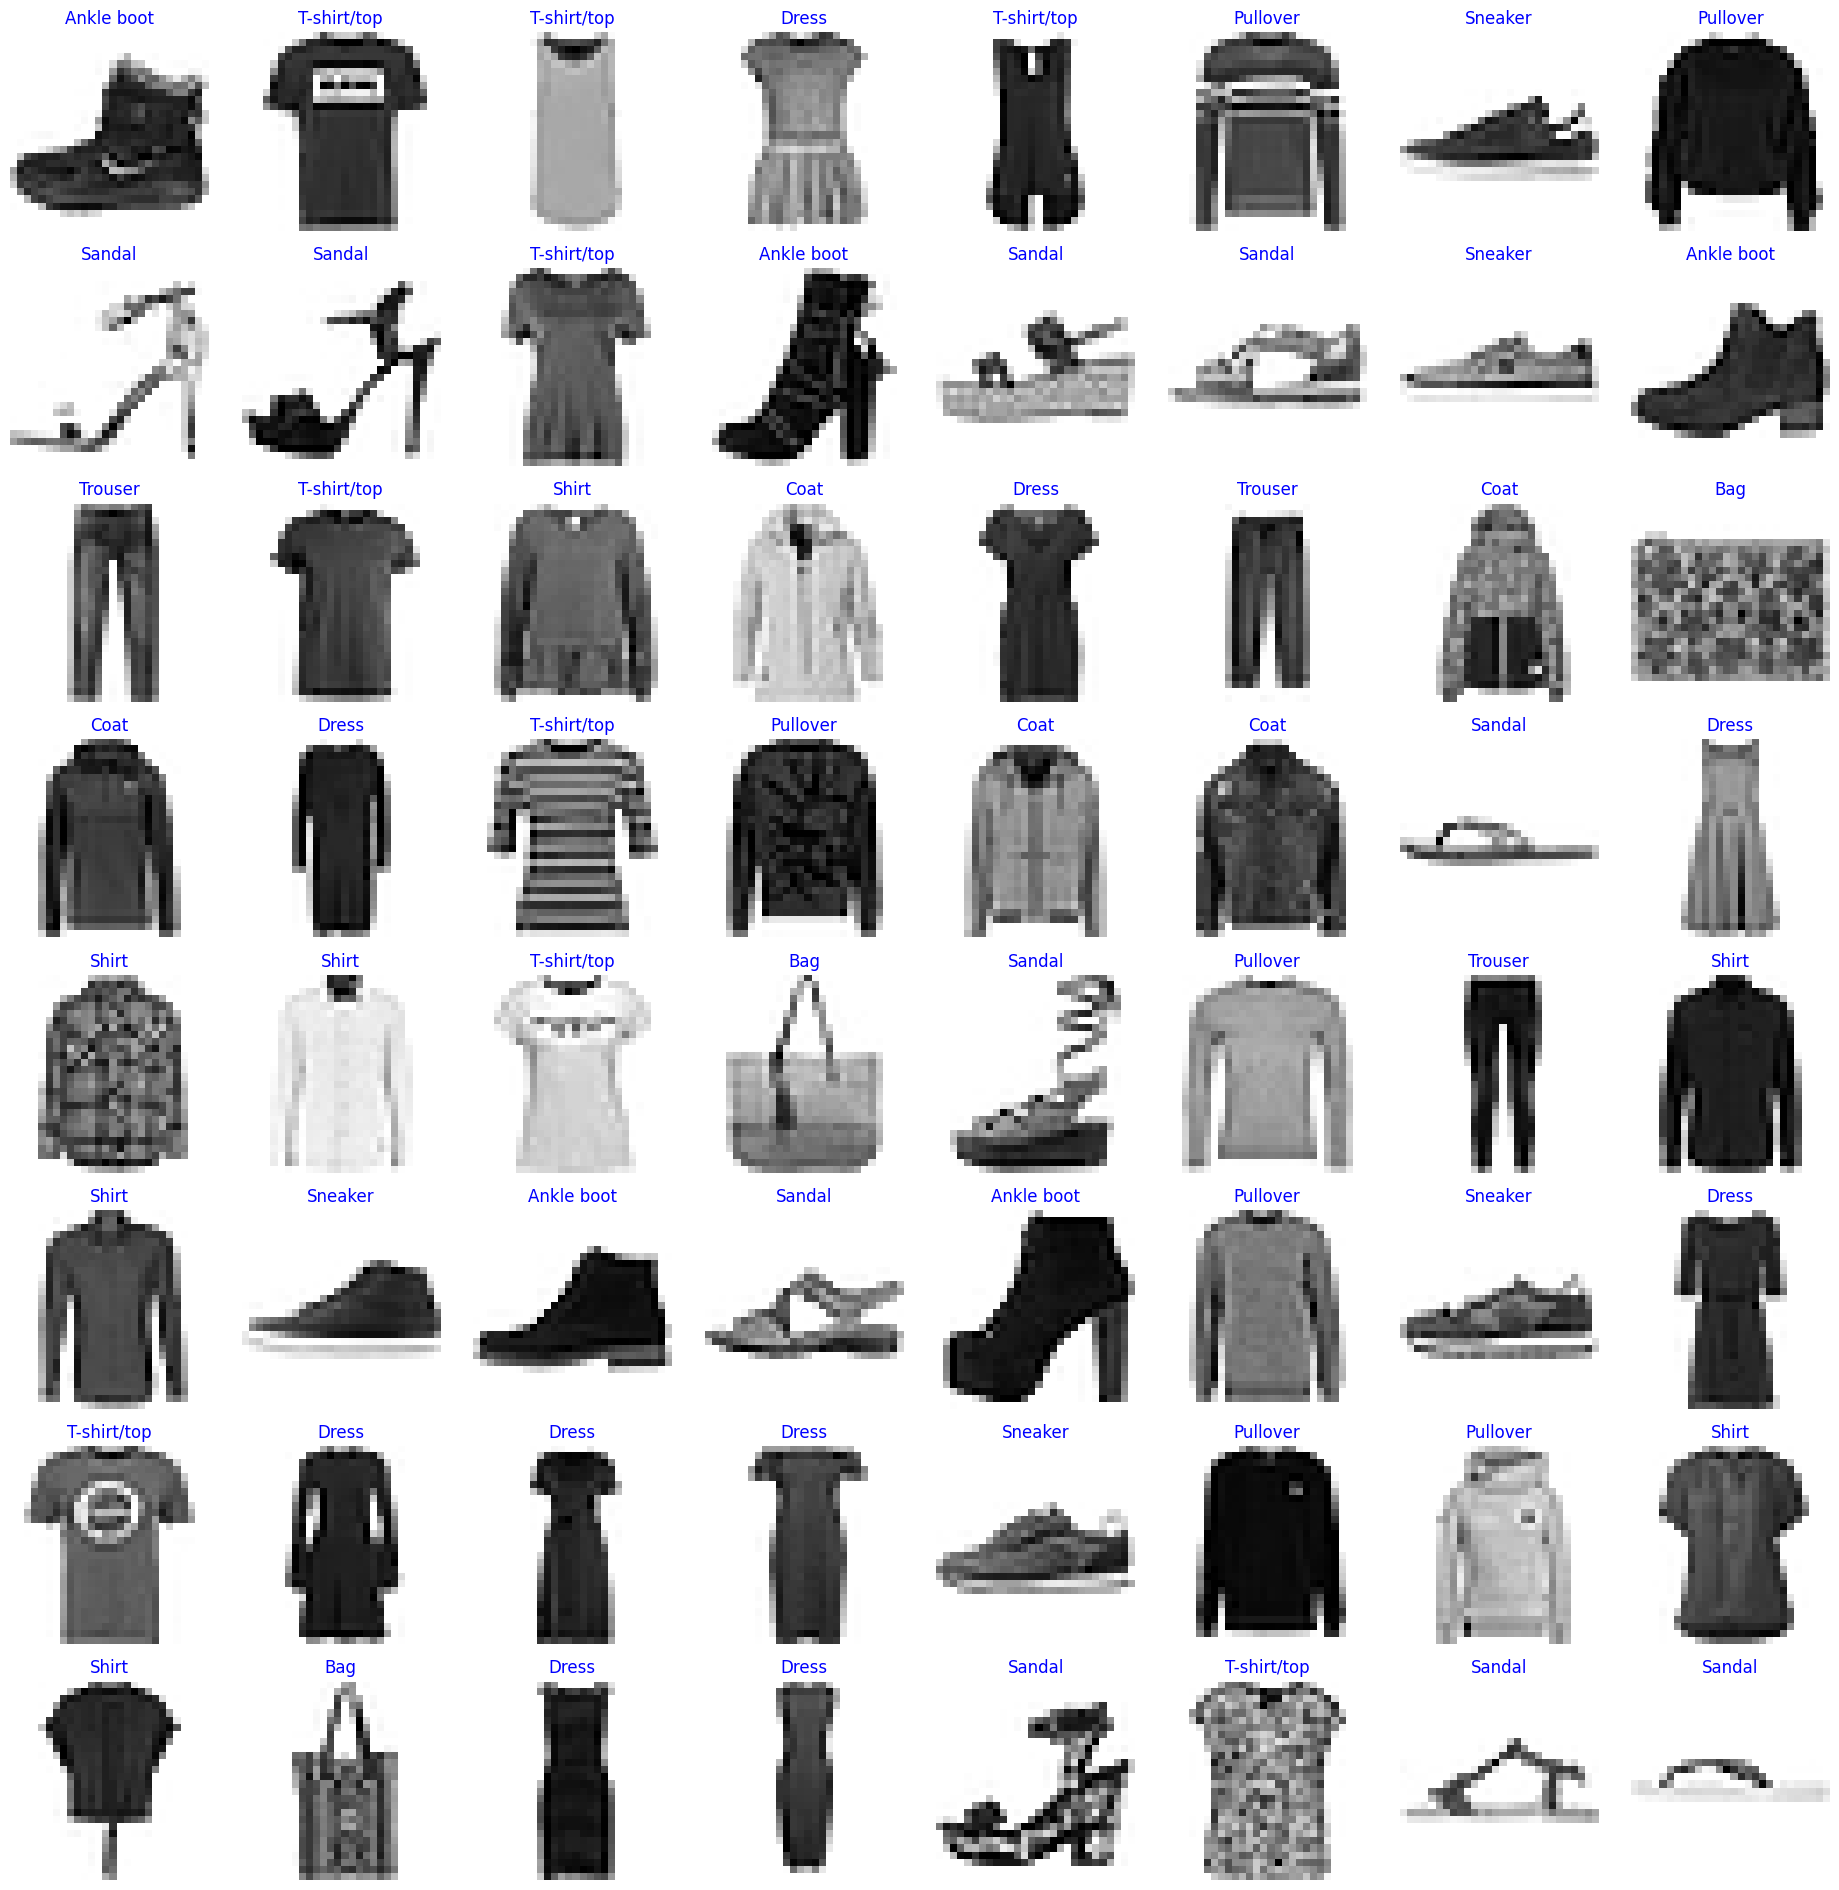

In [5]:
n_rows = 8
n_cols = 8
plt.figure(figsize=(19, 19))
for row in range(n_rows):
    for col in range(n_cols):
        index = row * n_cols + col
        plt.subplot(n_rows, n_cols, index + 1)
        plot_image(X_train[index], y_train[index])

plt.show()

From their documentation, the data is already cleaned for us, so no image preprocessing is required (I don't think I'm better than the expert at this).

In [6]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
  array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])),
 (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
  array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])))

There are ten classes, with the exact same amount across all of them in both train and test set.
Here are the class names and their corresponding indices:

| Index | Class Name    |
|-------|---------------|
| 0     | T-shirt/top   |
| 1     | Trouser       |
| 2     | Pullover      |
| 3     | Dress         |
| 4     | Coat          |
| 5     | Sandal        |
| 6     | Shirt         |
| 7     | Sneaker       |
| 8     | Bag           |
| 9     | Ankle boot    |

In [7]:
# Optionally, here are the scaled version of the X sets, though I think you shouldn't use it
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

## Logistic Regression

### Train Linear Model - Logistic Regression

Training with native logistic regression first

In [9]:
from cuml.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

log_reg = LogisticRegression(max_iter=10000)

kf = KFold(n_splits=3, shuffle=True, random_state=42)
accuracies = []

# do cross-validation with cuml LogisticRegression
for train_index, val_index in kf.split(X_train_scaled):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    log_reg.fit(X_train_fold, y_train_fold)
    
    y_pred = log_reg.predict(X_val_fold)
    accuracy = accuracy_score(y_val_fold, y_pred)
    accuracies.append(accuracy)

print(f"Accuracy of cuML logistic regression: {np.mean(accuracies):.2f}")


Accuracy of cuML logistic regression: 0.84


### Tuning Logistic Regression Model

I use `GridSearchCV` to search the best.

Parameters will be fine tune are:
- `C`: regularization, because it helps prevent **overfiting**, if it too small, model will be overfit, otherwise model will be underfit.

In [6]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
solvers = ['qn'] # 'qn' is equal to 'newton-cg' of scikit-learn
best_accuracy = 0
best_params = {}

kf = KFold(n_splits=3, shuffle=True, random_state=42)

for C in C_values:
    for solver in solvers:
        accuracies = []
        for train_index, val_index in kf.split(X_train_scaled):
            X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
            
            # init model with hyper params
            model = LogisticRegression(C=C, solver=solver, max_iter=10000) # max_iter to make sure that model converged
            
            # train model
            model.fit(X_train_fold, y_train_fold)
            
            
            # predict on valid
            y_pred = model.predict(X_val_fold)
            accuracy = accuracy_score(y_val_fold, y_pred)
            accuracies.append(accuracy)
        
        # calculate mean accuracy
        avg_accuracy = np.mean(accuracies)
        print(f"Parameters: C={C}, solver={solver} => Accuracy: {avg_accuracy:.2f}")
        
        # update params if these are better 
        if avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy
            best_params = {'C': C, 'solver': solver}

print("\nBest parameters:", best_params)
print("Best accuracy:", best_accuracy)

Parameters: C=0.001, solver=qn => Accuracy: 0.85

Parameters: C=0.01, solver=qn => Accuracy: 0.86

Parameters: C=0.1, solver=qn => Accuracy: 0.85

Parameters: C=1, solver=qn => Accuracy: 0.84

Parameters: C=10, solver=qn => Accuracy: 0.83

Parameters: C=100, solver=qn => Accuracy: 0.83

Parameters: C=1000, solver=qn => Accuracy: 0.83



Best parameters: {'C': 0.01, 'solver': 'qn'}

Best accuracy: 0.8568166666666667


### Evaluate Logistic Regression Model

Train all training data, then evaluate on test set with metrics

Metrics:
- Accuracy
- Precision
- Recall
- F1 Score

In [18]:
import pickle
from cuml.linear_model import LogisticRegression
import time

start_time = time.time()
best_logistic_regression = LogisticRegression(C=0.01,solver='qn', max_iter=10000)
best_logistic_regression.fit(X_train_scaled, y_train) # the whole data set
training_time = time.time() - start_time

# Save the model to a file
with open("cuml_logistic_regression_model.pkl", "wb") as f:
    pickle.dump(best_logistic_regression, f)


In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
    
start_time = time.time()
y_pred_log_reg = best_logistic_regression.predict(X_test_scaled)

acc_score = accuracy_score(y_test, y_pred_log_reg)
prec_score = precision_score(y_test, y_pred_log_reg, average='macro')
rec_score = recall_score(y_test, y_pred_log_reg, average='macro')
f1 = f1_score(y_test, y_pred_log_reg, average='macro')
cm = confusion_matrix(y_test, y_pred_log_reg)
evaluation_time = time.time() - start_time

print(f"Training time: {training_time}")
print(f"Evaluation time: {evaluation_time}")
print(f"Accuracy on test set: {acc_score:.6f}")
print(f"Precision score on test set: {prec_score:.6f}")
print(f"Recall score on test set: {rec_score:.6f}")
print(f"f1 score on test set: {f1:.6f}")

Training time: 53.040340423583984
Evaluation time: 0.052018165588378906
Accuracy on test set: 0.846700
Precision score on test set: 0.845527
Recall score on test set: 0.846700
f1 score on test set: 0.845797


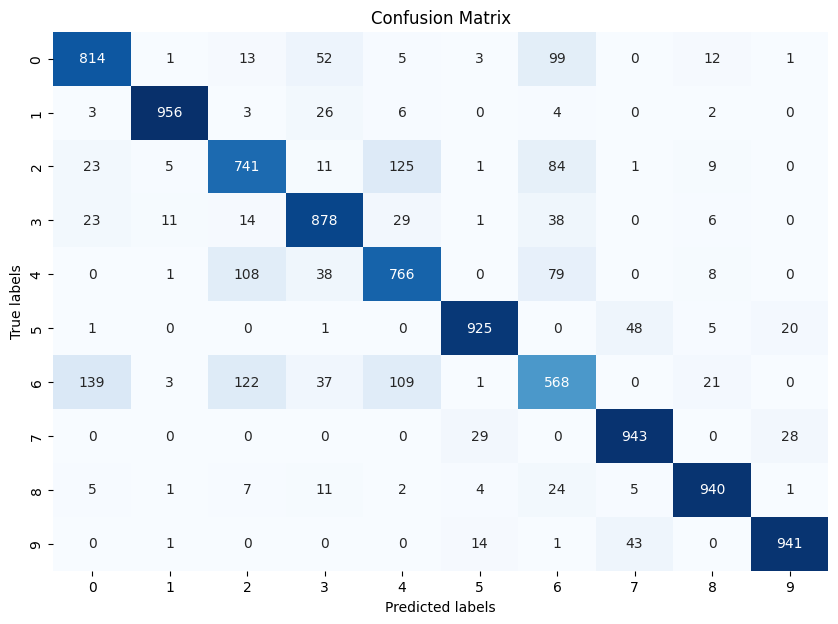

In [13]:
# plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar = False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

### Discuss about Logistic Regression with observed patterns

In [17]:
wrong_indexes = np.where(y_test != y_pred_log_reg)[0]
print(f"There are {len(wrong_indexes)} wrong predicted cases")

There are 1529 wrong predicted cases


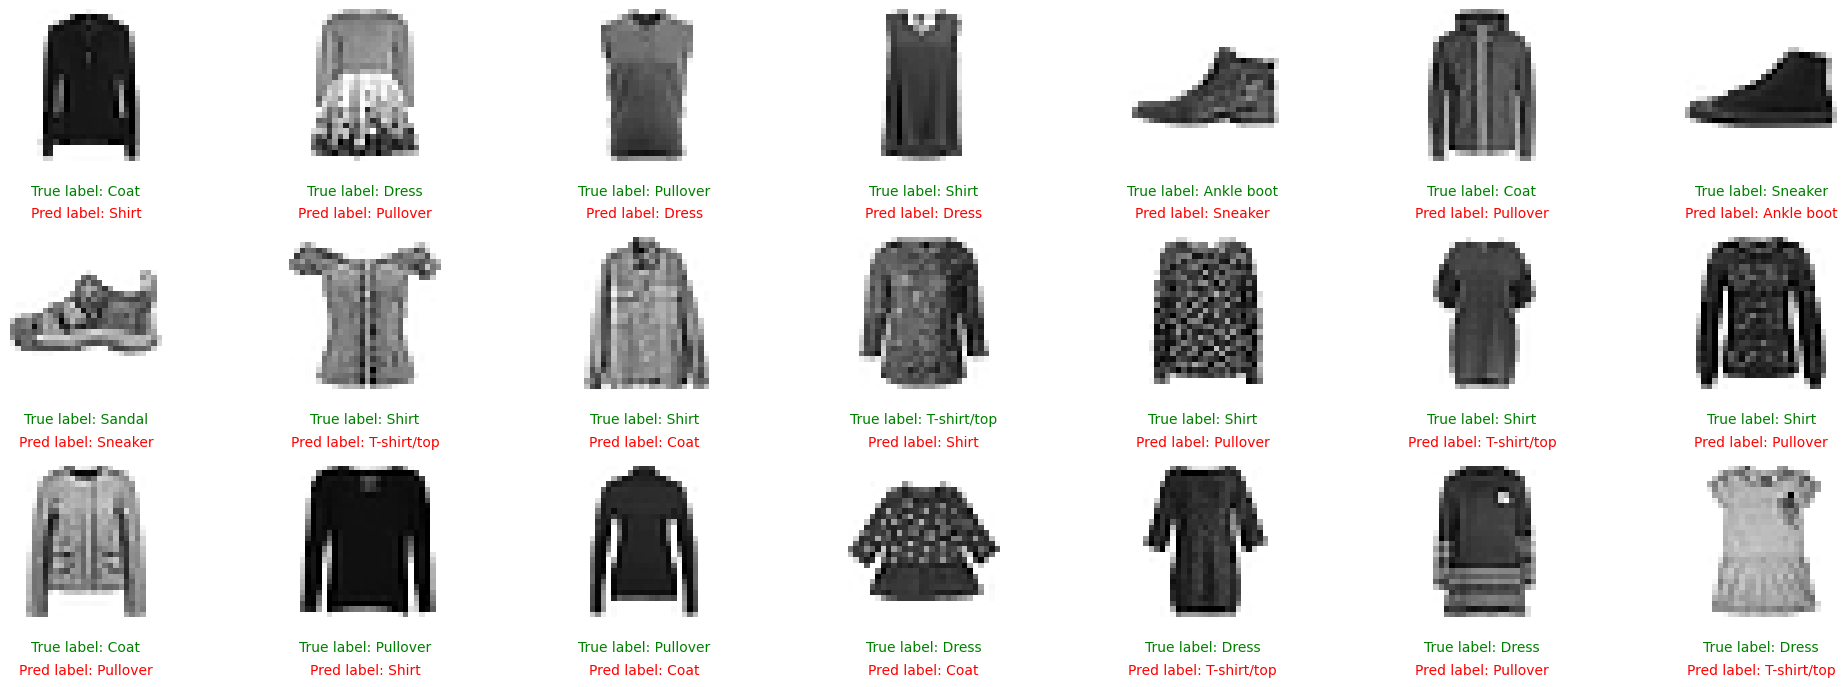

In [20]:
N = 21
random_indexes = np.random.choice(wrong_indexes, size=N, replace=False)
plt.figure(figsize=(20, 7))
n_cols = 7
n_rows = int(np.ceil(N/n_cols))


for row in range(n_rows):
    for col in range(n_cols):
        index = row * n_cols + col
        if index < N:
            plt.subplot(n_rows, n_cols, index + 1)
            image_index = random_indexes[index]
            right_label = y_test[image_index]
            wrong_label = y_pred_log_reg[image_index]
            image_data = X_test[image_index].reshape(28, 28)
            plt.imshow(image_data, cmap="binary")
            plt.axis("off")

            plt.text(
                0.5, -0.15, f"True label: {class_name[right_label]}", color="green", ha="center", va="top", transform=plt.gca().transAxes
            )
            plt.text(
                0.5, -0.3, f"Pred label: {class_name[wrong_label]}", color="red", ha="center", va="top", transform=plt.gca().transAxes
            )

plt.tight_layout()
plt.show()

**1. Similar Shape and Silhouette:**
- The model often misclassifies items with similar shapes or silhouettes, such as "T-shirt/top" as "Shirt" and "Pullover" as "Shirt." These types of clothing items share a similar outline, which can be hard to distinguish in grayscale or low-resolution images, as the model may struggle to capture subtle differences in collar shape, sleeve length, or fabric texture.

**2. Confusion between Clothing Categories:**

- Instances of "Dress" are often predicted as "Coat" or "T-shirt/top." Dresses and coats can sometimes have similar lengths and shapes, particularly when rendered in grayscale, making it challenging for the model to differentiate between these items without additional color or texture information.

**3. Accessory and Clothing Misclassification:**

- There are examples where items like "Bag" and "Shirt" are confused, likely due to the presence of rectangular shapes in bags that can resemble certain shirt outlines in low-resolution images. This type of error suggests that the model may need to learn more specific features related to accessories versus apparel to avoid such confusion.
    
**4. Footwear Confusion:**

- The model occasionally mistakes "Sneaker" for "Sandal," possibly because both share similar shapes, especially in simplified images. This error suggests that the model might not be fully capturing unique footwear characteristics, like the open design of sandals versus the closed structure of sneakers.

<a href="https://www.kaggle.com/code/huvinh/svm-kfold-hypertuning?scriptVersionId=204100654" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## SVM

In [15]:
import cuml
from cuml.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
import gc
import torch 

### Finetuning

In this step, we will fine-tune the model on the training dataset using the K-Fold Cross Validation technique. However, because training on a large dataset can be time-intensive, we will use the `cuML` library by RapidsAI instead of the `SVC` model from `scikit-learn`.

The `cuML` library provides models with algorithms similar to `scikit-learn` but optimized for computation on the GPU rather than the CPU. This approach enables faster results.


In [10]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

param_grid = {'C': [0.1, 1, 10, 100]}
best_score = 0
best_params = {}

for C in param_grid['C']:
    fold_scores = []
    for train_index, test_index in kf.split(X_train_scaled):
        X_train, X_val = X_train_scaled[train_index], X_train_scaled[test_index]
        y_train_fold, y_val = y_train[train_index], y_train[test_index]
        model = LinearSVC(C=C)
        model.fit(X_train, y_train_fold)

        y_pred = model.predict(X_val)
        score = accuracy_score(y_pred, y_val)
        fold_scores.append(score)
        
        del model
        gc.collect()
        torch.cuda.empty_cache()

    avg_score = round(np.mean(fold_scores),6)
    print(f"Độ chính xác trung bình với C={C}: {avg_score}")

    if avg_score > best_score:
        best_score = avg_score
        best_params = {'C': C}

print("Tham số tốt nhất:", best_params)
print("Độ chính xác cao nhất:", best_score)

Độ chính xác trung bình với C=0.1: 0.850167

Độ chính xác trung bình với C=1: 0.8491

Độ chính xác trung bình với C=10: 0.8485

Độ chính xác trung bình với C=100: 0.8486

Tham số tốt nhất: {'C': 0.1}

Độ chính xác cao nhất: 0.850167


In [13]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'auto'],
    'kernel': ['rbf']
}

best_score = 0
best_params = {}

for C in param_grid['C']:
    for gamma in param_grid['gamma']:
        for kernel in param_grid['kernel']:

            fold_scores = []

            for train_index, test_index in kf.split(X_train_scaled):
                X_train, X_val = X_train_scaled[train_index], X_train_scaled[test_index]
                y_train_fold, y_val = y_train[train_index], y_train[test_index]

                model = SVC(C=C, gamma=gamma, kernel=kernel)
                model.fit(X_train, y_train_fold)

                y_pred = model.predict(X_val)
                score = accuracy_score(y_val, y_pred)
                fold_scores.append(score)
                
                del model
                gc.collect()
                torch.cuda.empty_cache()

            avg_score = round(np.mean(fold_scores),6)
            print(f"Độ chính xác trung bình với C={C}, gamma={gamma}, kernel={kernel}: {round(avg_score,6)}")

            if avg_score > best_score:
                best_score = avg_score
                best_params = {'C': C, 'gamma': gamma, 'kernel': kernel}



print("Tham số tốt nhất:", best_params)
print("Độ chính xác cao nhất:", best_score)

Độ chính xác trung bình với C=0.1, gamma=1, kernel=rbf: 0.09755

Độ chính xác trung bình với C=0.1, gamma=0.1, kernel=rbf: 0.09755

Độ chính xác trung bình với C=0.1, gamma=0.01, kernel=rbf: 0.640167

Độ chính xác trung bình với C=0.1, gamma=0.001, kernel=rbf: 0.84755

Độ chính xác trung bình với C=0.1, gamma=0.0001, kernel=rbf: 0.793467

Độ chính xác trung bình với C=0.1, gamma=auto, kernel=rbf: 0.849817

Độ chính xác trung bình với C=1, gamma=1, kernel=rbf: 0.098283

Độ chính xác trung bình với C=1, gamma=0.1, kernel=rbf: 0.178817

Độ chính xác trung bình với C=1, gamma=0.01, kernel=rbf: 0.7991

Độ chính xác trung bình với C=1, gamma=0.001, kernel=rbf: 0.8881

Độ chính xác trung bình với C=1, gamma=0.0001, kernel=rbf: 0.851283

Độ chính xác trung bình với C=1, gamma=auto, kernel=rbf: 0.890633

Độ chính xác trung bình với C=10, gamma=1, kernel=rbf: 0.098333

Độ chính xác trung bình với C=10, gamma=0.1, kernel=rbf: 0.199517

Độ chính xác trung bình với C=10, gamma=0.01, kernel=rbf: 0.8

### Training and Evaluation 2 SVC models with best parameters

In the following step, I will create a custom class to store essential information for model evaluation. This class will include:

- Training time
- Evaluation time
- Accuracy
- Precision
- Recall
- F1-score
- Confusion matrix


In [14]:
class Model:
    def __init__(self, name, model, X_train, y_train, X_test, y_test):
        self.name = name
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.train_time = None
        self.evaluate_time = None
        self.y_pred = None
        self.accuracy = None
        self.precision = None
        self.recall = None
        self.f1_score = None
        self.confusion_matrix = None

    def train(self):
        start_time = time.time()
        self.model.fit(self.X_train, self.y_train)
        self.train_time = time.time() - start_time

    def evaluate(self):
        start_time = time.time()

        self.y_pred = self.model.predict(self.X_test)

        self.accuracy = accuracy_score(self.y_test, self.y_pred)
        self.precision = precision_score(self.y_test, self.y_pred, average='weighted')
        self.recall = recall_score(self.y_test, self.y_pred, average='weighted')
        self.f1_score = f1_score(self.y_test, self.y_pred, average='weighted')
        self.confusion_matrix = confusion_matrix(self.y_test, self.y_pred)

        self.evaluate_time = time.time() - start_time

    def display_metrics(self):
        print(f"Model Name: {self.name}")
        print(f"Training Time: {self.train_time:.4f} seconds")
        print(f"Evaluation Time: {self.evaluate_time:.4f} seconds")
        print(f"Accuracy: {self.accuracy:.6f}")
        print(f"Precision: {self.precision:.6f}")
        print(f"Recall: {self.recall:.6f}")
        print(f"F1-score: {self.f1_score:.6f}")

        plt.figure(figsize=(8, 6))
        sns.heatmap(self.confusion_matrix, cmap="Reds", annot=True, fmt='g')
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

Model Name: Linear Kernel SVC
Training Time: 6.4390 seconds
Evaluation Time: 0.0417 seconds
Accuracy: 0.840500
Precision: 0.838054
Recall: 0.840500
F1-score: 0.838158


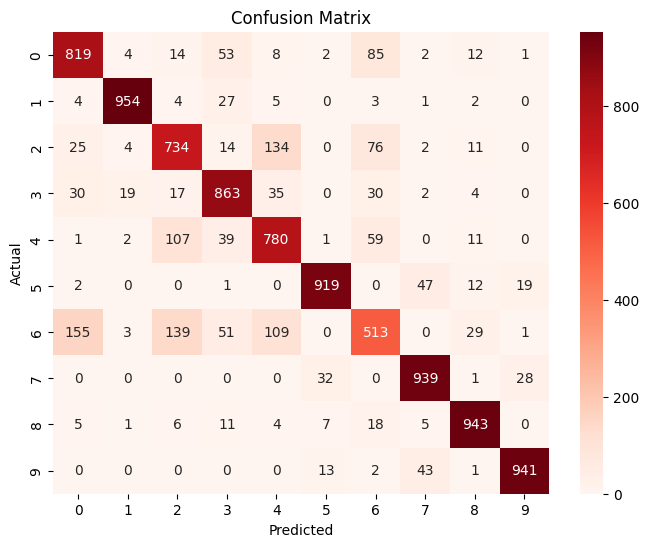

In [16]:
linear = Model(name="Linear Kernel SVC", model=LinearSVC(C=0.1), X_train=X_train_scaled, y_train=y_train, X_test=X_test_scaled, y_test=y_test)
linear.train()
linear.evaluate()
linear.display_metrics()
with open('linear_model.pkl', 'wb') as file:
    pickle.dump(linear.model, file)

Model Name: RBF_SVC
Training Time: 24.4439 seconds
Evaluation Time: 8.4204 seconds
Accuracy: 0.899500
Precision: 0.899252
Recall: 0.899500
F1-score: 0.899313


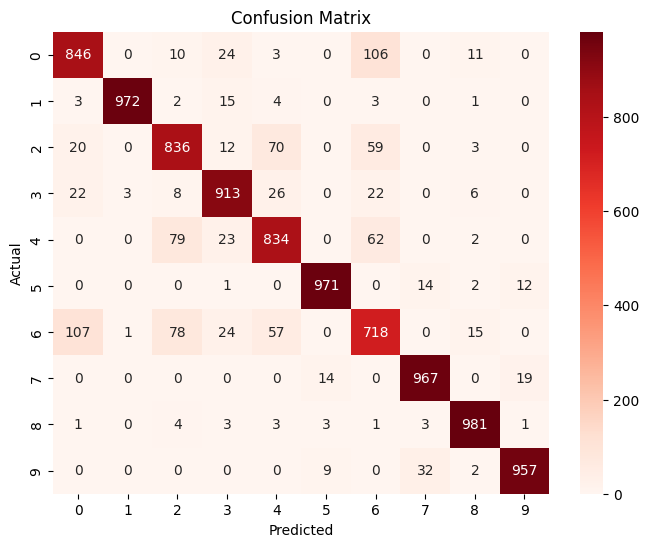

In [17]:
rbf = Model(name="RBF_SVC", model=SVC(C= 10, gamma= 'auto', kernel= 'rbf'), X_train=X_train_scaled, y_train=y_train, X_test=X_test_scaled, y_test=y_test)
rbf.train()
rbf.evaluate()
rbf.display_metrics()
with open('rbf_model.pkl', 'wb') as file:
    pickle.dump(rbf.model, file)

# Apply Dimensionality Reduction Techniques

## Data Loading and Preprocessing

In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

(X_train, y_train), (X_test, y_test) =  tf.keras.datasets.fashion_mnist.load_data()

In [21]:
print(f"Train set shape: {X_train.shape, y_train.shape}\nTest set shape: {X_test.shape, y_test.shape}")

Train set shape: ((60000, 28, 28), (60000,))
Test set shape: ((10000, 28, 28), (10000,))


In [22]:
X_train: np.ndarray = X_train.reshape(X_train.shape[0], 784)
X_test: np.ndarray = X_test.reshape(X_test.shape[0], 784)

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

## Visualizing the mean representation of each class

This visualization highlights the typical (mean) look of each class, showing both highly representative (closest) and diverse (furthest) examples within each category. The mean images provide a clear, generalized view of each class, while the closest samples align closely with these averages, representing typical features. The furthest samples reveal intra-class diversity, showing variations that deviate significantly from the mean. This analysis indicates that PCA could reduce dimensionality effectively by capturing core class differences, even with noticeable variations within each class.

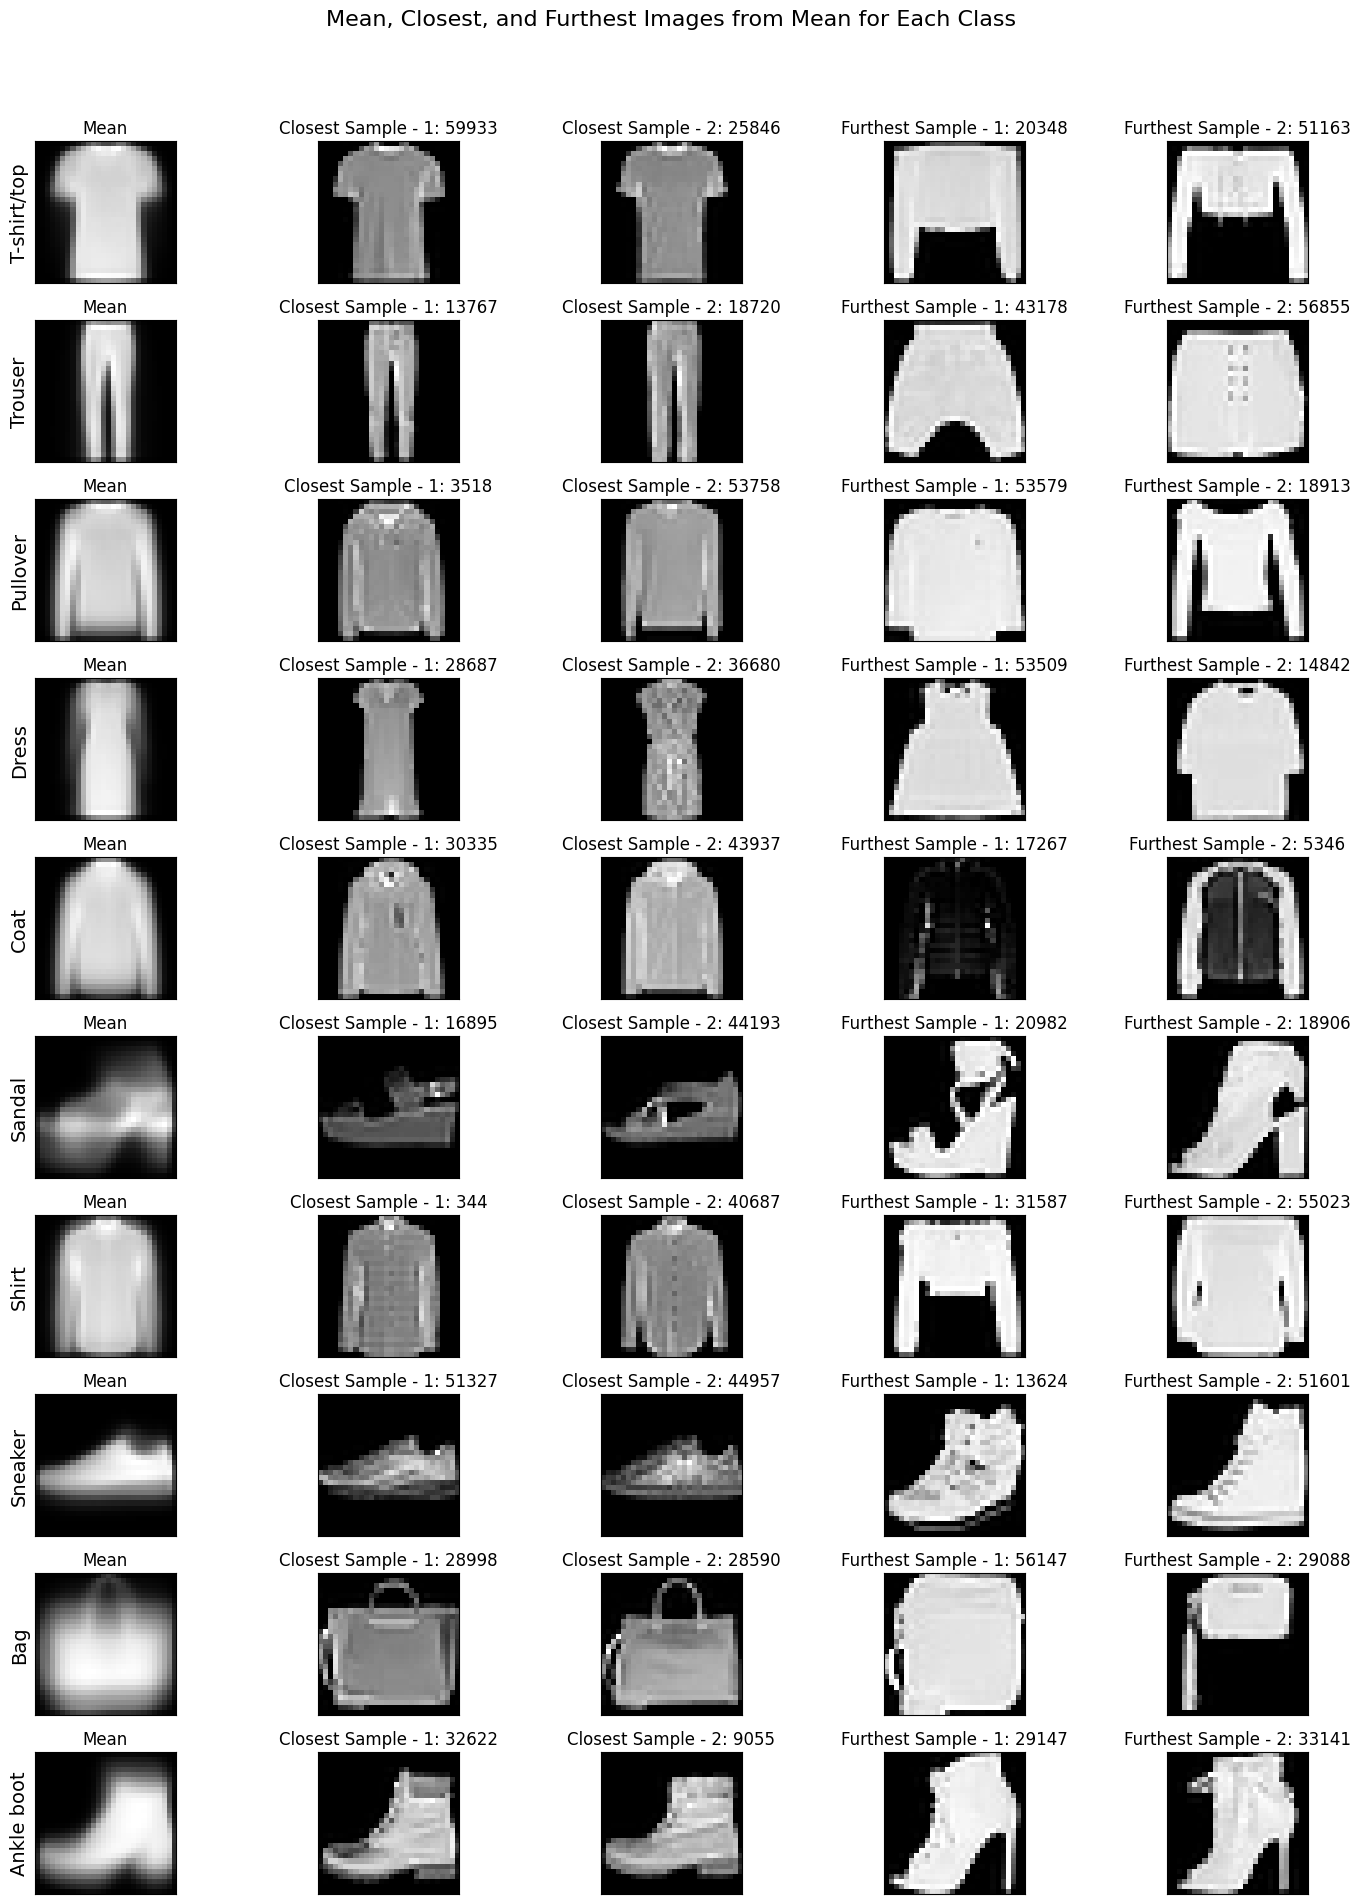

In [24]:
from scipy.spatial import distance

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig, axes = plt.subplots(10, 5, figsize=(15, 20))
fig.suptitle('Mean, Closest, and Furthest Images from Mean for Each Class', fontsize=16)

for i, label in enumerate(np.unique(y_train)):
    class_images = X_train[y_train == label]
    mean_image = class_images.mean(axis=0)

    # Compute distances from each image in the class to the mean
    distances = np.array([distance.euclidean(mean_image, img) for img in class_images])

    # Get indices for the closest and furthest images
    closest_indices = distances.argsort()[:2]
    furthest_indices = distances.argsort()[-2:]

    # Plot mean image
    axes[i, 0].imshow(mean_image.reshape(28, 28), cmap='gray')
    axes[i, 0].set_title("Mean")
    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])
    axes[i, 0].set_ylabel(class_names[label], fontsize=14)

    # Plot the closest images with sample IDs
    for j, idx in enumerate(closest_indices):
        axes[i, j+1].imshow(class_images[idx].reshape(28, 28), cmap='gray')
        axes[i, j+1].set_title(f"Closest Sample - {j+1}: {np.where(y_train == label)[0][idx]}")
        axes[i, j+1].set_xticks([])
        axes[i, j+1].set_yticks([])

    # Plot the furthest images with sample IDs
    for j, idx in enumerate(furthest_indices):
        axes[i, j+3].imshow(class_images[idx].reshape(28, 28), cmap='gray')
        axes[i, j+3].set_title(f"Furthest Sample - {j+1}: {np.where(y_train == label)[0][idx]}")
        axes[i, j+3].set_xticks([])
        axes[i, j+3].set_yticks([])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Applying PCA for Dimensionality Reduction

Now, we will apply PCA to reduce the dimensionality of the data and get quick insights into the explained variance ratio. We will visualize the cumulative explained variance to determine the number of principal components needed to capture most of the data variance.

In [25]:
from sklearn.decomposition import PCA

X_train_scaled_copy = X_train_scaled.copy()

# Fit PCA
pca = PCA()
pca.fit(X_train_scaled_copy)

print(f"First 10 PCs: {pca.explained_variance_[:10]}")

First 10 PCs: [173.13789644 113.01260323  42.81633652  39.89596074  31.79084015
  23.67336435  21.54106703  18.13934684  13.27049633  10.33363286]


In [26]:
print(f"Explained variance ratio of first 10 PCs: {pca.explained_variance_ratio_[:10]}")

Explained variance ratio of first 10 PCs: [0.22083547 0.14414633 0.05461176 0.05088686 0.04054887 0.03019511
 0.02747539 0.02313654 0.01692637 0.01318043]


### How to choose the number of dimensions $K$ of the new data

One way to determine $K$ is based on the amount of information that we want to retain. Theoretically, PCA is also known as the maximum retained variance method. So we can consider the sum of the retained variances as the amount of information retained. The larger the variance, the more dispersed the data is, and the larger the amount of information it represents.

Recall that in every coordinate system, the total variance of the data is the same and equals the sum of the eigenvalues ​​of the covariance matrix $\sum_{i=1}^D \lambda_i$. Furthermore, PCA helps to retain the amount of information (total variance) as: $\sum_{i=1}^K \lambda_i$. Therefore, we can consider the expression:

$$r_K = \frac{\sum_{i=1}^K \lambda_i}{\sum_{j=1}^D \lambda_j}$$

So, let's say we want to keep 99% of the data, we just need to choose $K$ as the smallest natural number such that $r_K \geq 0.99$.

In [27]:
# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the smallest K such that cumulative variance >= 0.99
K = np.argmax(cumulative_variance >= 0.99) + 1

print(f"Number of dimensions K to retain 99% of the variance: {K}")

Number of dimensions K to retain 99% of the variance: 527


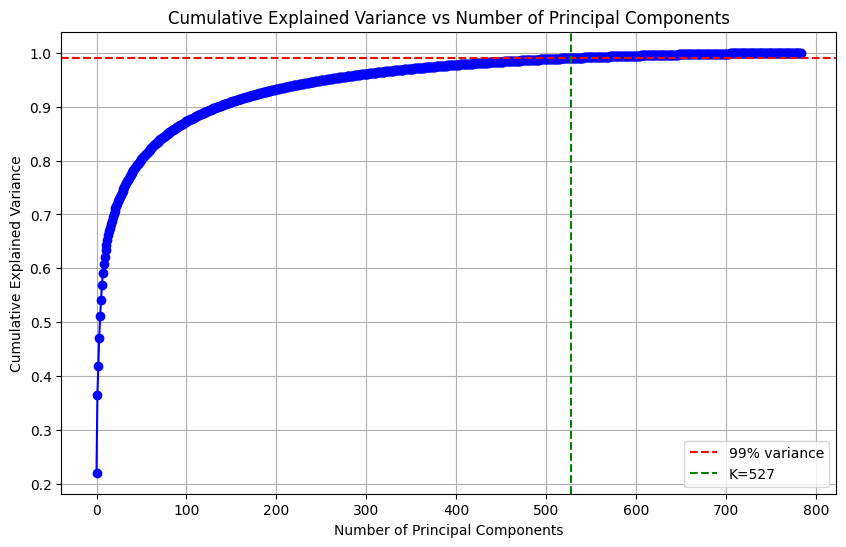

In [28]:
# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='-', color='b')
plt.axhline(y=0.99, color='r', linestyle='--', label='99% variance')
plt.axvline(x=K, color='g', linestyle='--', label=f'K={K}')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of Principal Components')
plt.legend()
plt.grid(True)
plt.show()

Because the data retained $99 \%$ of the information has $K$ value too large that can negatively affect the model's performance. Therefore, we can choose $K$ as the smallest natural number such that $r_K \in [0.8, 0.9]$. Eventually, I think that we should experiment with $K$ value being $100$ to see how the model performs.

In [29]:
print(f"Cumulative explained variance at K=100: {cumulative_variance[99]}")

Cumulative explained variance at K=100: 0.8715402148875268


In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Train set shape after PCA: {X_train_pca.shape}\nTest set shape after PCA: {X_test_pca.shape}")

Train set shape after PCA: (60000, 100)
Test set shape after PCA: (10000, 100)


In [31]:
# Save the data
np.save('X_train_pca.npy', X_train_pca)
np.save('X_test_pca.npy', X_test_pca)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

## Visualizing the reduced dimensionality data

We will visualize the first 18 principal components to observe the data distribution in a lower-dimensional space. This visualization helps us understand how well the reduced data captures the original data structure and class separability.

(784, 100)


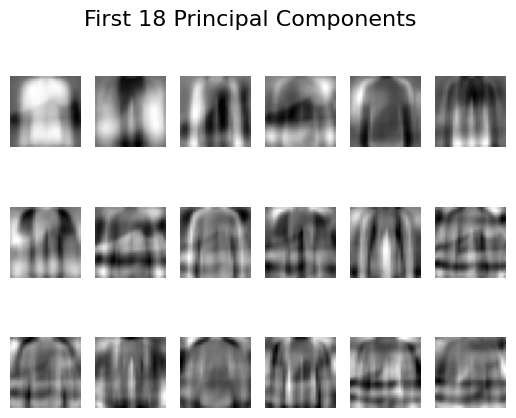

In [32]:
U_K = pca.components_.T # U_K is a matrix whose columns are the eigenvectors
print(U_K.shape)

plt.suptitle('First 18 Principal Components', fontsize=16)
for row in range(18):
    plt.subplot(3, 6, row + 1)
    plt.axis('off')
    plt.imshow(U_K[:, row].reshape(28, 28), cmap='gray')

The first 18 principal components capture key patterns of variation, highlighting common contours and structural features in the dataset. Early components show prominent edges and shapes, representing the most significant differences across images. This suggests that a reduced number of components can effectively retain essential information for classification while reducing complexity.

After dimensionality reduction, the training set takes up much less space. For example, after applying PCA to the Fashion-MNIST dataset while preserving $\approx 87 \%$ of its variance, we are left with $100$ features, instead of the original $784$ features. So the dataset is now less than $\approx 12.76 \%$ of its original size, and we only lost $\approx 13 \%$  of its variance.

It is also possible to decompress the reduced dataset back to $784$ dimensions by applying the inverse transformation of the PCA projection. This won't give us back the original data, since the projection lost a bit of information (within the $13 \%$ variance that was dropped), but it will likely be close to the original data.

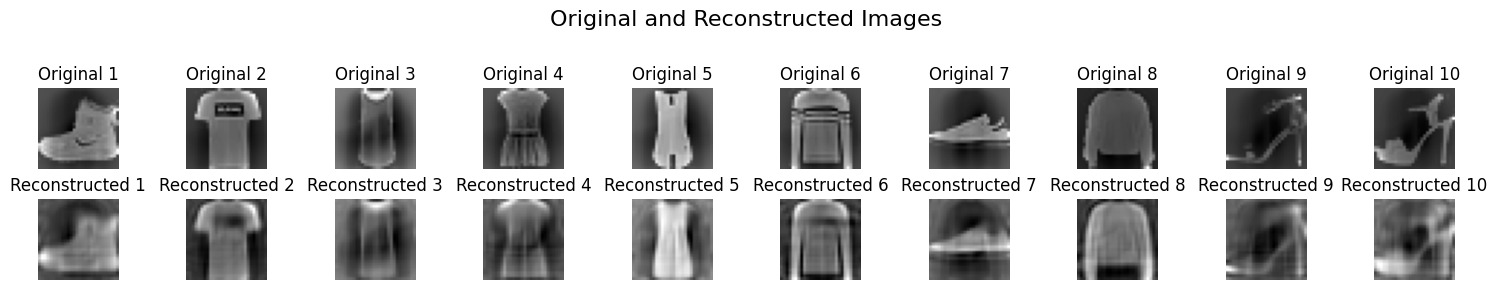

In [33]:
# Reconstruct the images
X_train_reconstructed = pca.inverse_transform(X_train_pca)
X_test_reconstructed = pca.inverse_transform(X_test_pca)

fig, axes = plt.subplots(2, 10, figsize=(15, 3))
fig.suptitle('Original and Reconstructed Images', fontsize=16)

for i in range(10):
    axes[0, i].imshow(X_train_scaled[i].reshape(28, 28), cmap='gray')
    axes[0, i].set_title(f"Original {i+1}")
    axes[0, i].axis('off')

    axes[1, i].imshow(X_train_reconstructed[i].reshape(28, 28), cmap='gray')
    axes[1, i].set_title(f"Reconstructed {i+1}")
    axes[1, i].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Retrain the Model

In this section, we will retrain the model using the reduced dimensionality data and evaluate its performance on the test set. We will compare the model's performance before and after dimensionality reduction to assess the impact of PCA on classification accuracy in the next section [Compare the performance of the models for the original and reduced dimensionality data](#compare-the-performance-of-the-models-for-the-original-and-reduced-dimensionality-data)

## Logistic Regression

### Experimenting in the Data

In [34]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, log_loss

X_train_pca = np.load('X_train_pca.npy')
X_test_pca = np.load('X_test_pca.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

log_reg = LogisticRegression(max_iter=10000)

kf = KFold(n_splits=3, shuffle=True, random_state=42)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for fold, (train_index, val_index) in enumerate(kf.split(X_train_pca)):
    print(f"Fold {fold + 1}")

    X_train_fold, X_val_fold = X_train_pca[train_index], X_train_pca[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    log_reg.fit(X_train_fold, y_train_fold)

    y_train_pred = log_reg.predict(X_train_fold)
    y_val_pred = log_reg.predict(X_val_fold)

    train_loss = log_loss(y_train_fold, log_reg.predict_proba(X_train_fold))
    train_accuracy = accuracy_score(y_train_fold, y_train_pred)

    val_loss = log_loss(y_val_fold, log_reg.predict_proba(X_val_fold))
    val_accuracy = accuracy_score(y_val_fold, y_val_pred)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

print(f"\nAverage Train Loss: {np.mean(train_losses):.4f}")
print(f"Average Val Loss: {np.mean(val_losses):.4f}")
print(f"Average Train Accuracy: {np.mean(train_accuracies):.4f}")
print(f"Average Val Accuracy: {np.mean(val_accuracies):.4f}")

Fold 1
Train Loss: 0.4126, Val Loss: 0.4462, Train Acc: 0.8554, Val Acc: 0.8489
Fold 2
Train Loss: 0.4130, Val Loss: 0.4419, Train Acc: 0.8558, Val Acc: 0.8487
Fold 3
Train Loss: 0.4099, Val Loss: 0.4477, Train Acc: 0.8556, Val Acc: 0.8484

Average Train Loss: 0.4118
Average Val Loss: 0.4453
Average Train Accuracy: 0.8556
Average Val Accuracy: 0.8487


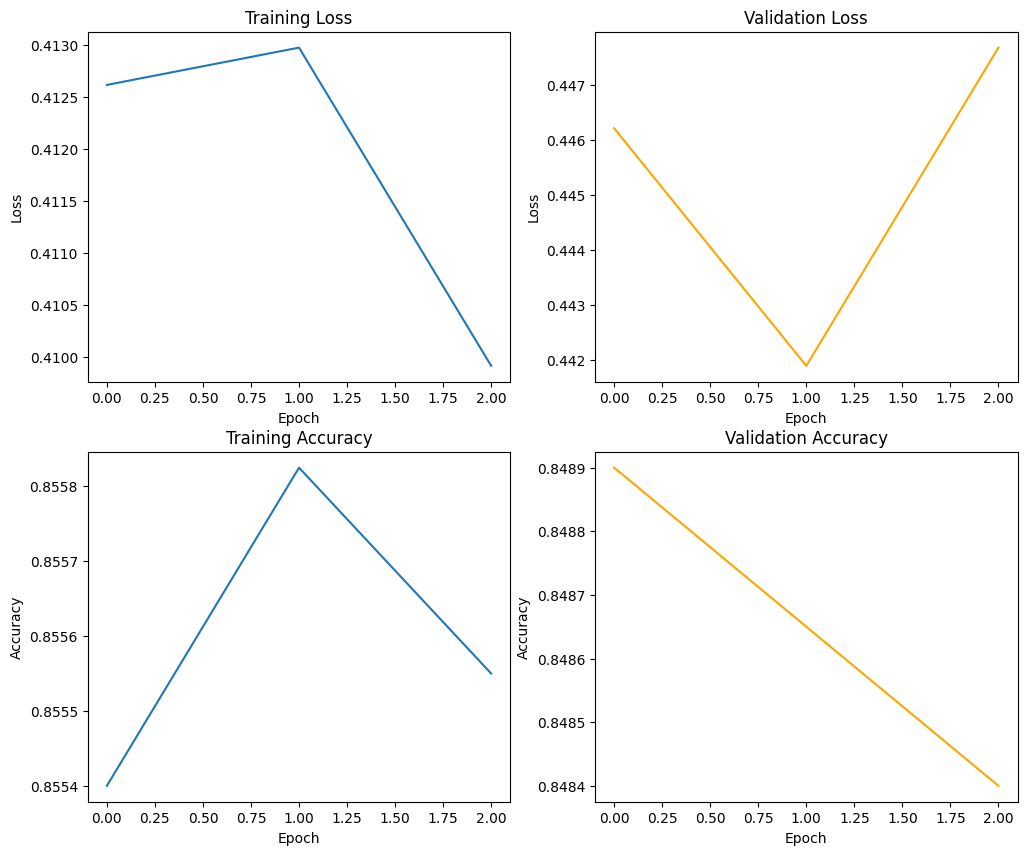

In [35]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, 'orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accuracies)
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accuracies, 'orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

### Tuning the hyperparameters

In [36]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, log_loss

C_values = [0.01, 0.1, 1, 10]
solver_values = ['lbfgs', 'saga', 'newton-cg']

best_accuracy = 0
best_params = {}

kf = KFold(n_splits=3, shuffle=True, random_state=42)

X_train_pca = np.load('X_train_pca.npy')
X_test_pca = np.load('X_test_pca.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

for C in C_values:
    for solver in solver_values:
        print(f"Training with C={C}, solver={solver}")

        log_reg = LogisticRegression(C=C, solver=solver, max_iter=10000)

        train_accuracies = []
        val_accuracies = []

        for fold, (train_index, val_index) in enumerate(kf.split(X_train_pca)):
            X_train_fold, X_val_fold = X_train_pca[train_index], X_train_pca[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            log_reg.fit(X_train_fold, y_train_fold)

            y_train_pred = log_reg.predict(X_train_fold)
            y_val_pred = log_reg.predict(X_val_fold)

            train_accuracy = accuracy_score(y_train_fold, y_train_pred)
            val_accuracy = accuracy_score(y_val_fold, y_val_pred)

            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

        avg_val_accuracy = np.mean(val_accuracies)
        print(f"Average Validation Accuracy: {avg_val_accuracy:.4f}")

        if avg_val_accuracy > best_accuracy:
            best_accuracy = avg_val_accuracy
            best_params = {'C': C, 'solver': solver}

Training with C=0.01, solver=lbfgs
Average Validation Accuracy: 0.8458
Training with C=0.01, solver=saga
Average Validation Accuracy: 0.8443
Training with C=0.01, solver=newton-cg
Average Validation Accuracy: 0.8457
Training with C=0.1, solver=lbfgs
Average Validation Accuracy: 0.8487
Training with C=0.1, solver=saga
Average Validation Accuracy: 0.8463
Training with C=0.1, solver=newton-cg
Average Validation Accuracy: 0.8488
Training with C=1, solver=lbfgs
Average Validation Accuracy: 0.8487
Training with C=1, solver=saga
Average Validation Accuracy: 0.8474
Training with C=1, solver=newton-cg
Average Validation Accuracy: 0.8485
Training with C=10, solver=lbfgs
Average Validation Accuracy: 0.8484
Training with C=10, solver=saga
Average Validation Accuracy: 0.8473
Training with C=10, solver=newton-cg
Average Validation Accuracy: 0.8483


In [37]:
print(f"\nBest Validation Accuracy: {best_accuracy:.4f}")
print(f"Best Parameters: {best_params}")


Best Validation Accuracy: 0.8488
Best Parameters: {'C': 0.1, 'solver': 'newton-cg'}


In [38]:
import pickle
import time

start_time = time.time()
best_log_reg = LogisticRegression(C=best_params['C'], solver=best_params['solver'], max_iter=10000)
best_log_reg.fit(X_train_pca, y_train)
training_time = time.time() - start_time

with open("best_log_reg.pkl", "wb") as f:
    pickle.dump(best_log_reg, f)

In [39]:
best_log_reg = pickle.load(open("best_log_reg.pkl", "rb"))
y_test_pred = best_log_reg.predict(X_test_pca)
print(f"Prediction on test set: {y_test_pred}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

Prediction on test set: [9 2 1 ... 8 1 5]
Test Accuracy: 0.8365


### Evaluation

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

def print_evaluation_table(metrics_dict, conf_matrix=None):
    """
    Function to print a table of evaluation metrics and display the confusion matrix.

    Parameters:
        - metrics_dict (dict): A dictionary containing metric names as keys and metric values as values.
        - conf_matrix (np.ndarray): A confusion matrix.

    Returns:
        None: This function does not return anything. It prints the evaluation table and displays the confusion matrix.
    """
    # Length of the "Metric" and "Score" columns for alignment
    max_metric_len = max(len(metric) for metric in metrics_dict.keys())
    table_width = max_metric_len + 13  # width for the column and the '|' character

    print("Metric Evaluation Table:")
    print("+" + "-" * (table_width) + "+")
    print("| {0:<{width}} |   Score  |".format("Metric", width=max_metric_len))
    print("+" + "-" * (table_width) + "+")

    for metric, score in metrics_dict.items():
        print("| {0:<{width}} | {1:>8.4f} |".format(metric, score, width=max_metric_len))
    print("+" + "-" * (table_width) + "+")

    if conf_matrix is not None:
        plt.figure(figsize=(10, 7))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar = False)
        plt.xlabel("Predicted labels")
        plt.ylabel("True labels")
        plt.title("Confusion Matrix")
        plt.show()

Metric Evaluation Table:
+----------------------+
| Metric    |   Score  |
+----------------------+
| Accuracy  |   0.8365 |
| Precision |   0.8352 |
| Recall    |   0.8365 |
| F1 Score  |   0.8356 |
+----------------------+


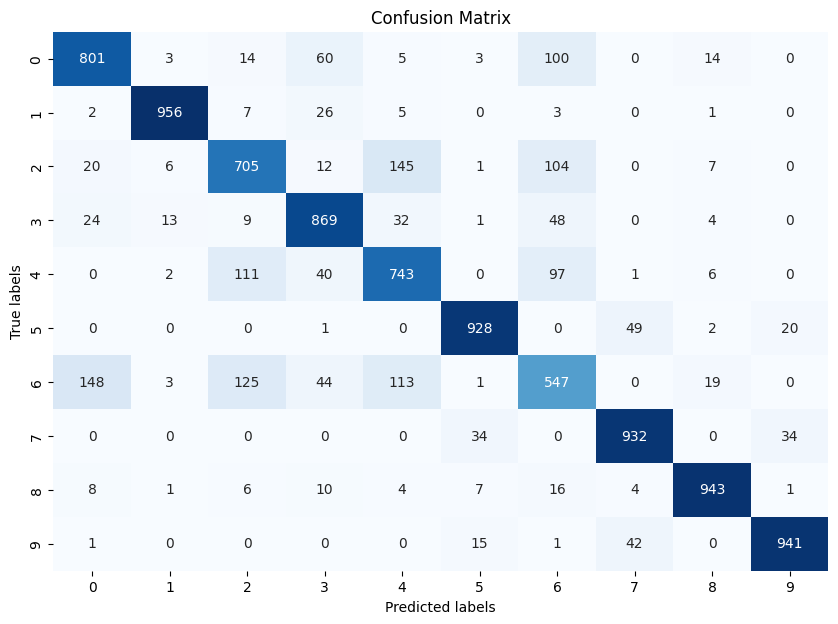

Training time: 18.81210494041443
Evaluation time: 0.1085519790649414


In [41]:
metrics = {
    'Accuracy': accuracy_score(y_test, y_test_pred),
    'Precision': precision_score(y_test, y_test_pred, average='macro'),
    'Recall': recall_score(y_test, y_test_pred, average='macro'),
    'F1 Score': f1_score(y_test, y_test_pred, average='macro')
}

start_time = time.time()
conf_matrix = confusion_matrix(y_test, y_test_pred)

print_evaluation_table(metrics, conf_matrix)
evaluation_time = time.time() - start_time

print(f"Training time: {training_time}")
print(f"Evaluation time: {evaluation_time}")

### Visualizing the results with true and predicted labels

In [42]:
wrong_indices = np.where(y_test != y_test_pred)[0]
print(f"Number of misclassified samples: {len(wrong_indices)}")

Number of misclassified samples: 1635


In [43]:
import numpy as np
import matplotlib.pyplot as plt

def plot_wrong_predictions(X_test, y_test, y_test_pred, wrong_indices, N=21):
    """
    Plot wrong predictions in a grid format.

    Parameters:
    - X_test: numpy array of test images.
    - y_test: numpy array of true labels for the test images.
    - y_test_pred: numpy array of predicted labels for the test images.
    - wrong_indices: list or numpy array of indices where predictions were incorrect.
    - N: number of wrong predictions to display (default is 21).
    """
    # Randomly select N wrong indices without replacement
    random_wrong_indices = np.random.choice(wrong_indices, N, replace=False)

    # Set figure size and determine number of rows and columns
    plt.figure(figsize=(20, 7))
    n_cols = 7
    n_rows = N // n_cols + 1

    # Define class names
    class_names = {
        0: "T-shirt/top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle boot",
    }

    # Plot each selected wrong prediction
    for row in range(n_rows):
        for col in range(n_cols):
            index = row * n_cols + col
            if index < N:
                plt.subplot(n_rows, n_cols, index + 1)
                img_index = random_wrong_indices[index]
                right_label = y_test[img_index]
                wrong_label = y_test_pred[img_index]
                img = X_test[img_index].reshape(28, 28)

                # Display image and add labels
                plt.imshow(img, cmap='gray')
                plt.axis('off')
                plt.text(0.5, -0.15, f"True: {class_names[right_label]}", color='green', ha="center", va="top", transform=plt.gca().transAxes)
                plt.text(0.5, -0.25, f"Pred: {class_names[wrong_label]}", color='red', ha="center", va="top", transform=plt.gca().transAxes)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

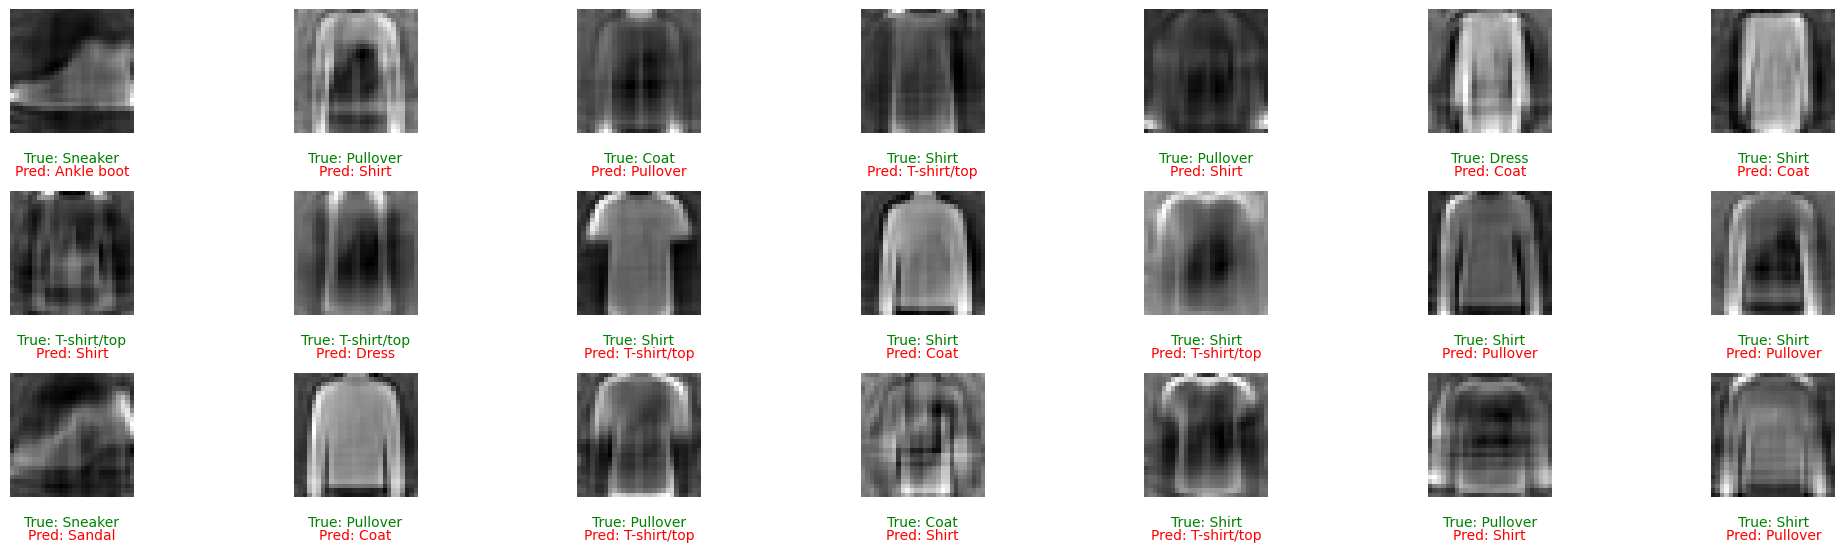

In [44]:
plot_wrong_predictions(X_test_reconstructed, y_test, y_test_pred, wrong_indices, N=21)

## Support Vector Machine

### Experimenting in the Data

In [45]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import KFold

X_train_pca = np.load('X_train_pca.npy')
X_test_pca = np.load('X_test_pca.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

svm = SVC(kernel='rbf', C=1, gamma='scale') # `gamma='scale'` is the default value

kf = KFold(n_splits=3, shuffle=True, random_state=42)

train_accuracies = []
val_accuracies = []

for fold, (train_index, val_index) in enumerate(kf.split(X_train_pca)):
    print(f"Fold {fold + 1}")

    X_train_fold, X_val_fold = X_train_pca[train_index], X_train_pca[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    svm.fit(X_train_fold, y_train_fold)

    y_train_pred = svm.predict(X_train_fold)
    y_val_pred = svm.predict(X_val_fold)

    train_accuracy = accuracy_score(y_train_fold, y_train_pred)
    val_accuracy = accuracy_score(y_val_fold, y_val_pred)

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

Fold 1
Train Acc: 0.9013, Val Acc: 0.8831
Fold 2
Train Acc: 0.9008, Val Acc: 0.8814
Fold 3
Train Acc: 0.9011, Val Acc: 0.8808


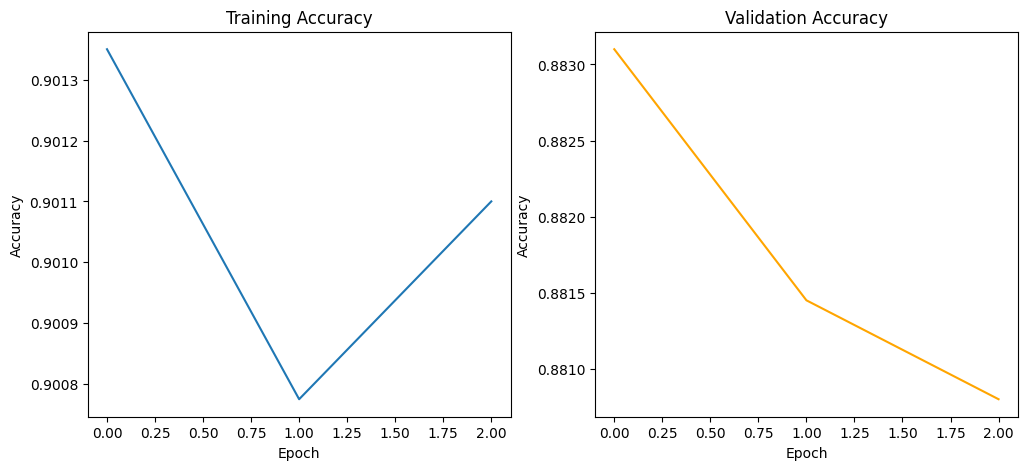

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_accuracies)
ax[0].set(xlabel='Epoch', ylabel='Accuracy')
ax[0].set_title('Training Accuracy')

ax[1].plot(val_accuracies, 'orange')
ax[1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1].set_title('Validation Accuracy')

plt.show()

### Tuning the hyperparameters

In [47]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

C_values = [0.01, 0.1, 1, 10]
kernel_values = ['linear', 'poly', 'rbf']

best_accuracy = 0
best_params = {}

kf = KFold(n_splits=3, shuffle=True, random_state=42)

X_train_pca = np.load('X_train_pca.npy')
X_test_pca = np.load('X_test_pca.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

for C in C_values:
    for kernel in kernel_values:
        print(f"Training with C={C}, kernel={kernel}")

        svm = SVC(C=C, kernel=kernel, gamma='scale')

        train_accuracies = []
        val_accuracies = []

        for fold, (train_index, val_index) in enumerate(kf.split(X_train_pca)):
            X_train_fold, X_val_fold = X_train_pca[train_index], X_train_pca[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            svm.fit(X_train_fold, y_train_fold)

            y_train_pred = svm.predict(X_train_fold)
            y_val_pred = svm.predict(X_val_fold)

            train_accuracy = accuracy_score(y_train_fold, y_train_pred)
            val_accuracy = accuracy_score(y_val_fold, y_val_pred)

            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

        avg_val_accuracy = np.mean(val_accuracies)
        print(f"Average Validation Accuracy: {avg_val_accuracy:.4f}")

        if avg_val_accuracy > best_accuracy:
            best_accuracy = avg_val_accuracy
            best_params = {'C': C, 'kernel': kernel}

Training with C=0.01, kernel=linear
Average Validation Accuracy: 0.8571
Training with C=0.01, kernel=poly
Average Validation Accuracy: 0.6883
Training with C=0.01, kernel=rbf
Average Validation Accuracy: 0.7734
Training with C=0.1, kernel=linear
Average Validation Accuracy: 0.8587
Training with C=0.1, kernel=poly
Average Validation Accuracy: 0.8129
Training with C=0.1, kernel=rbf
Average Validation Accuracy: 0.8433
Training with C=1, kernel=linear
Average Validation Accuracy: 0.8578
Training with C=1, kernel=poly
Average Validation Accuracy: 0.8721
Training with C=1, kernel=rbf
Average Validation Accuracy: 0.8818
Training with C=10, kernel=linear
Average Validation Accuracy: 0.8579
Training with C=10, kernel=poly
Average Validation Accuracy: 0.8917
Training with C=10, kernel=rbf
Average Validation Accuracy: 0.8966


In [48]:
print(f"\nBest Validation Accuracy: {best_accuracy:.4f}")
print(f"Best Parameters: {best_params}")


Best Validation Accuracy: 0.8966
Best Parameters: {'C': 10, 'kernel': 'rbf'}


In [49]:
import pickle
import time

start_time = time.time()
best_svm = SVC(C=best_params['C'], kernel=best_params['kernel'], gamma='scale')
best_svm.fit(X_train_pca, y_train)
training_time = time.time() - start_time

with open("best_svm.pkl", "wb") as f:
    pickle.dump(best_svm, f)

In [50]:
best_svm = pickle.load(open("best_svm.pkl", "rb"))
y_test_pred = best_svm.predict(X_test_pca)
print(f"Prediction on test set: {y_test_pred}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

Prediction on test set: [9 2 1 ... 8 1 5]
Test Accuracy: 0.8922


### Evaluation

Metric Evaluation Table:
+----------------------+
| Metric    |   Score  |
+----------------------+
| Accuracy  |   0.8922 |
| Precision |   0.8918 |
| Recall    |   0.8922 |
| F1 Score  |   0.8918 |
+----------------------+


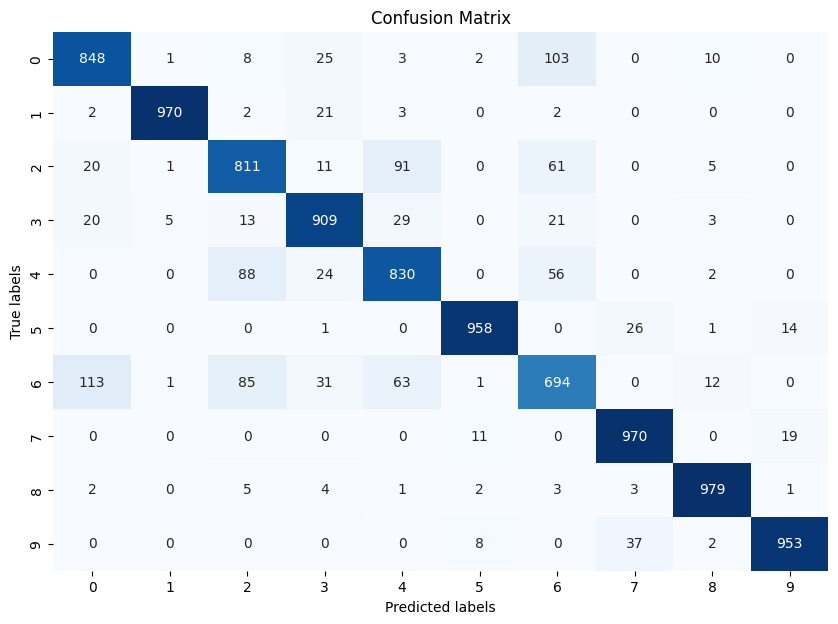

Training time: 21.78242802619934
Evaluation time: 0.35063719749450684


In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

metrics = {
    'Accuracy': accuracy_score(y_test, y_test_pred),
    'Precision': precision_score(y_test, y_test_pred, average='macro'),
    'Recall': recall_score(y_test, y_test_pred, average='macro'),
    'F1 Score': f1_score(y_test, y_test_pred, average='macro')
}

start_time = time.time()
conf_matrix = confusion_matrix(y_test, y_test_pred)

print_evaluation_table(metrics, conf_matrix)
evaluation_time = time.time() - start_time

print(f"Training time: {training_time}")
print(f"Evaluation time: {evaluation_time}")

### Visualizing the results with true and predicted labels

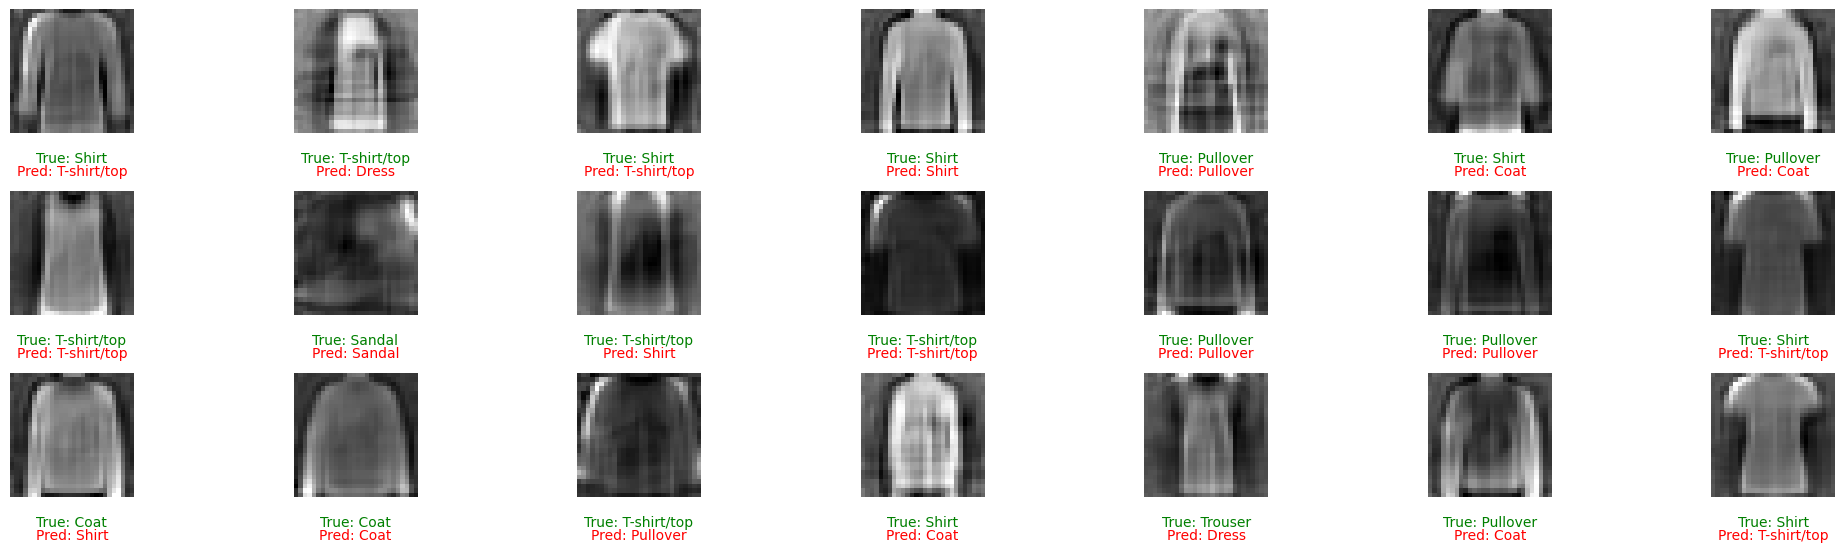

In [52]:
plot_wrong_predictions(X_test_reconstructed, y_test, y_test_pred, wrong_indices, N=21)